# 03_DetectOpening

In [14]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

from metpy.calc import wind_components
from metpy.units import units

import gsw
import gsw.freezing

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import cmocean

# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy import img_transform

sys.path.append('../../')
import plot_simply.general as plotter
import plot_simply.geomap as geomap
import data_UniBremen.SIC as UNISIC

import geofunc.shapes as geoshape


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from skimage.morphology import flood
from skimage.segmentation import find_boundaries
from skimage.morphology import disk
from scipy.ndimage import binary_fill_holes

In [16]:
def return_indices(binary_grid, ii, jj, ii_size, jj_size):
    
    ii_l = ii-ii_size
    ii_r = ii+ii_size+1
    jj_l = jj-jj_size
    jj_r = jj+jj_size+1
    
    # adjust bounds for footprint edge conditions
    if ii_l < 0:
        ii_l_f = -ii_l
        ii_l = 0
    else:
        ii_l_f = 0

    if jj_l < 0:
        jj_l_f = -jj_l
        jj_l = 0
    else:
        jj_l_f = 0   

    if ii_r >= binary_grid.shape[0]:
        ii_r_f = binary_grid.shape[0]-ii_r
        ii_r = binary_grid.shape[0]
    else:
        ii_r_f = 1+2*ii_size

    if jj_r >= binary_grid.shape[1]:
        jj_r_f = binary_grid.shape[1]-jj_r
        jj_r = binary_grid.shape[1]
    else:
        jj_r_f = 1+2*jj_size
        
    return ii_l, ii_r, jj_l, jj_r, ii_l_f, ii_r_f, jj_l_f, jj_r_f

def grab_footprint(foot, binary_grid, keys, ii, jj, ii_size, jj_size):
            
    out = return_indices(binary_grid, ii, jj, ii_size, jj_size)
    ii_l, ii_r, jj_l, jj_r, ii_l_f, ii_r_f, jj_l_f, jj_r_f = out

    # crop footprint
    foot = foot[ii_l_f:ii_r_f, jj_l_f:jj_r_f]
    
    # crop to local values, and return those within footprint
    nearby_vals = binary_grid[ii_l:ii_r, jj_l:jj_r][foot]
    nearby_keys = keys[ii_l:ii_r, jj_l:jj_r][foot]

    return nearby_vals, nearby_keys


### Open sample file

In [17]:
date = datetime(2024,1,16)

# date = datetime(2016,2,29)
# date = datetime(2019,1,18)

# date = datetime(2022,11,28)
# date = datetime(2022,12,1)

# date = datetime(2007,12,1)

# date = datetime(2019,12,12)

sic = UNISIC.open_local_file(pd.to_datetime(date), res='6250', hem='n', 
                                 main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                             crop=[850,1250,150,350],
                                 coordinates=True, area=True, include_units=False, 
                                 quiet=True)


#### specify sic thresh and initialization points

In [18]:
#==================
# thresh = 60 # open ice 4/10-6/10
# thresh = 30 # very open ice 1/10-3/10
thresh = 10 # WMO open water
#==================

# https://nsidc.org/sites/default/files/wmo-259-2015_multilingual.pdf

# ia, ib = (8,13)
# ja, jb = (7,12)
# jgrid, igrid = np.meshgrid(np.arange(ja, jb), np.arange(ia, ib))

# grid of indices
keys = np.arange(np.shape(sic['xx'])[0]*np.shape(sic['xx'])[1]).reshape(np.shape(sic['xx'])[0], np.shape(sic['xx'])[1])


# create 50 km radius footprint to check
#==================
radius = 4
#==================
footprint = disk(radius).astype(bool)
ii_size = int((footprint.shape[0]-1)/2)
jj_size = int((footprint.shape[1]-1)/2)

radius_in_km = radius * np.diff(sic['xx'], axis=1)[0][0] / 1000
print(f'r = {radius_in_km} km')

r = 25.0 km


In [19]:
25/6.25

4.0

### Create box to enclose polynya region

In [20]:
# import pyproj

# # Define the bearing (in degrees) and the distance to travel (in meters)
# #==================
# bearing1 = 35
# #==================
# bearing2 = bearing1-90
# bearing3 = bearing2-90
# bearing4 = bearing3-90
# # distance = 15000 # m
# distance = 20000 # m


# geod = pyproj.Geod(ellps='WGS84') # Create a Geod object

# reg_lons = np.array([-139])
# reg_lats = np.array([69.35])

# reg_lonsp = np.copy(reg_lons)
# reg_latsp = np.copy(reg_lats)

# for ss in range(4):
#     lon2, lat2, _ = geod.fwd(reg_lons[-1], reg_lats[-1], bearing1, distance)
#     reg_lons = np.append(reg_lons, lon2)
#     reg_lats = np.append(reg_lats, lat2)
    
# for ss in range(27):
#     lon2, lat2, _ = geod.fwd(reg_lons[-1], reg_lats[-1], bearing2, distance)
#     reg_lons = np.append(reg_lons, lon2)
#     reg_lats = np.append(reg_lats, lat2)
   
# for ss in range(8):
#     lon2, lat2, _ = geod.fwd(reg_lons[-1], reg_lats[-1], bearing3, distance)
#     reg_lons = np.append(reg_lons, lon2)
#     reg_lats = np.append(reg_lats, lat2)
    
# for ss in range(14):
#     lon2, lat2, _ = geod.fwd(reg_lons[-1], reg_lats[-1], bearing4, distance)
#     reg_lons = np.append(reg_lons, lon2)
#     reg_lats = np.append(reg_lats, lat2)
    
    
    
# # reg_lons = np.append(reg_lons, -142.7)
# # reg_lats = np.append(reg_lats, 69.75)    

# bearing1 = 35
    
# # reg_lons = np.append(reg_lons, np.array([-153, -145, -139.5]))
# # reg_lats = np.append(reg_lats, np.array([70.1, 69.8, 69.3]))

# region_lons = reg_lons
# region_lats = reg_lats

# reg_poly = geoshape.make_polygon(np.stack((region_lons, region_lats), axis=1))

# # save coordinates to file
# # df = pd.DataFrame({'lons': region_lons,
# #                    'lats': region_lats})
# # df.to_csv('../data/coastal_region_bounds_v6.csv', index=False)  

### V6

In [21]:
# import pyproj

# # Define the bearing (in degrees) and the distance to travel (in meters)
# #==================
# bearing1 = 15
# #==================
# bearing2 = bearing1-90
# bearing3 = bearing2-90
# bearing4 = bearing3-90
# # distance = 15000 # m
# distance = 20000 # m


# geod = pyproj.Geod(ellps='WGS84') # Create a Geod object

# reg_lons = np.array([-139])
# reg_lats = np.array([69.35])

# reg_lonsp = np.copy(reg_lons)
# reg_latsp = np.copy(reg_lats)

# for ss in range(12):
#     lon2, lat2, _ = geod.fwd(reg_lons[-1], reg_lats[-1], bearing1, distance)
#     reg_lons = np.append(reg_lons, lon2)
#     reg_lats = np.append(reg_lats, lat2)
    
# for ss in range(25):
#     lon2, lat2, _ = geod.fwd(reg_lons[-1], reg_lats[-1], bearing2, distance)
#     reg_lons = np.append(reg_lons, lon2)
#     reg_lats = np.append(reg_lats, lat2)
   
# for ss in range(11):
#     lon2, lat2, _ = geod.fwd(reg_lons[-1], reg_lats[-1], bearing3, distance)
#     reg_lons = np.append(reg_lons, lon2)
#     reg_lats = np.append(reg_lats, lat2)
    
# for ss in range(26):
#     lon2, lat2, _ = geod.fwd(reg_lons[-1], reg_lats[-1], bearing4, distance)
#     reg_lons = np.append(reg_lons, lon2)
#     reg_lats = np.append(reg_lats, lat2)
    
    
    
# # reg_lons = np.append(reg_lons, -142.7)
# # reg_lats = np.append(reg_lats, 69.75)    

# # bearing1 = 35
    
# # reg_lons = np.append(reg_lons, np.array([-153, -145, -139.5]))
# # reg_lats = np.append(reg_lats, np.array([70.1, 69.8, 69.3]))

# region_lons = reg_lons
# region_lats = reg_lats

# reg_lons2 = reg_lons
# reg_lats2 = reg_lats

# reg_poly = geoshape.make_polygon(np.stack((region_lons, region_lats), axis=1))

# # save coordinates to file
# # df = pd.DataFrame({'lons': region_lons,
# #                    'lats': region_lats})
# # df.to_csv('../data/coastal_region_bounds_v6.csv', index=False)  

In [22]:
import pyproj

# Define the bearing (in degrees) and the distance to travel (in meters)
#==================
bearing1 = 15
#==================
bearing2 = bearing1-90
bearing3 = bearing2-90
bearing4 = bearing3-90
# distance = 15000 # m
distance = 20000 # m


geod = pyproj.Geod(ellps='WGS84') # Create a Geod object

reg_lons = np.array([-139])
reg_lats = np.array([69.35])

reg_lonsp = np.copy(reg_lons)
reg_latsp = np.copy(reg_lats)

for ss in range(9):
    lon2, lat2, _ = geod.fwd(reg_lons[-1], reg_lats[-1], bearing1, distance)
    reg_lons = np.append(reg_lons, lon2)
    reg_lats = np.append(reg_lats, lat2)
    
for ss in range(19):
    lon2, lat2, _ = geod.fwd(reg_lons[-1], reg_lats[-1], bearing2, distance)
    reg_lons = np.append(reg_lons, lon2)
    reg_lats = np.append(reg_lats, lat2)
   
for ss in range(8):
    lon2, lat2, _ = geod.fwd(reg_lons[-1], reg_lats[-1], bearing3, distance)
    reg_lons = np.append(reg_lons, lon2)
    reg_lats = np.append(reg_lats, lat2)
    
lon2, lat2, _ = geod.fwd(reg_lons[-1], reg_lats[-1], bearing3, distance/2)
reg_lons = np.append(reg_lons, lon2)
reg_lats = np.append(reg_lats, lat2)
    
# lon2, lat2, _ = geod.fwd(reg_lons[-1], reg_lats[-1], bearing3, distance/2)
# reg_lons = np.append(reg_lons, lon2)
# reg_lats = np.append(reg_lats, lat2)
    
for ss in range(20):
    lon2, lat2, _ = geod.fwd(reg_lons[-1], reg_lats[-1], bearing4, distance)
    reg_lons = np.append(reg_lons, lon2)
    reg_lats = np.append(reg_lats, lat2)
    
    
    
# reg_lons = np.append(reg_lons, -142.7)
# reg_lats = np.append(reg_lats, 69.75)    

# bearing1 = 35
    
# reg_lons = np.append(reg_lons, np.array([-153, -145, -139.5]))
# reg_lats = np.append(reg_lats, np.array([70.1, 69.8, 69.3]))

region_lons = reg_lons
region_lats = reg_lats

reg_lons2 = reg_lons
reg_lats2 = reg_lats

reg_poly = geoshape.make_polygon(np.stack((region_lons, region_lats), axis=1))

# save coordinates to file
# df = pd.DataFrame({'lons': region_lons,
#                    'lats': region_lats})
# df.to_csv('../data/coastal_region_bounds_v7.csv', index=False)  

### Smaller box

In [23]:
# import pyproj

# # Define the bearing (in degrees) and the distance to travel (in meters)
# #==================
# bearing1 = 15
# #==================
# bearing2 = bearing1-90
# bearing3 = bearing2-90
# bearing4 = bearing3-90
# # distance = 15000 # m
# distance = 20000 # m


# geod = pyproj.Geod(ellps='WGS84') # Create a Geod object

# reg_lons = np.array([-139])
# reg_lats = np.array([69.35])

# reg_lonsp = np.copy(reg_lons)
# reg_latsp = np.copy(reg_lats)

# for ss in range(12):
#     lon2, lat2, _ = geod.fwd(reg_lons[-1], reg_lats[-1], bearing1, distance)
#     reg_lons = np.append(reg_lons, lon2)
#     reg_lats = np.append(reg_lats, lat2)
    
# for ss in range(13):
#     lon2, lat2, _ = geod.fwd(reg_lons[-1], reg_lats[-1], bearing2, distance)
#     reg_lons = np.append(reg_lons, lon2)
#     reg_lats = np.append(reg_lats, lat2)
   
# for ss in range(12):
#     lon2, lat2, _ = geod.fwd(reg_lons[-1], reg_lats[-1], bearing3, distance)
#     reg_lons = np.append(reg_lons, lon2)
#     reg_lats = np.append(reg_lats, lat2)
    
# for ss in range(14):
#     lon2, lat2, _ = geod.fwd(reg_lons[-1], reg_lats[-1], bearing4, distance)
#     reg_lons = np.append(reg_lons, lon2)
#     reg_lats = np.append(reg_lats, lat2)
    
    
    
# # reg_lons = np.append(reg_lons, -142.7)
# # reg_lats = np.append(reg_lats, 69.75)    

# # bearing1 = 35
    
# # reg_lons = np.append(reg_lons, np.array([-153, -145, -139.5]))
# # reg_lats = np.append(reg_lats, np.array([70.1, 69.8, 69.3]))

# region_lons = reg_lons
# region_lats = reg_lats


# reg_poly = geoshape.make_polygon(np.stack((region_lons, region_lats), axis=1))

# # save coordinates to file
# # df = pd.DataFrame({'lons': region_lons,
# #                    'lats': region_lats})
# # df.to_csv('../data/coastal_region_smallerE_bounds_v6.csv', index=False)  

### Determine which coords within region analysis

In [24]:
from shapely.geometry import Point

within_region = np.full(sic['lon'].shape, False)

for ii in range(np.shape(within_region)[0]):
    for jj in range(np.shape(within_region)[1]):
         
        lon, lat = sic['lon'][ii,jj], sic['lat'][ii,jj]
        if lon > 180:
            lon-=360
        
        if reg_poly.contains(Point(lon, lat)):
            within_region[ii,jj] = True

## Define orientations along/against polynya axis

In [72]:
import pyproj

# Define the bearing (in degrees) and the distance to travel (in meters)
#==================
bearing1 = -55
#==================
bearing2 = bearing1+90
bearing3 = bearing1-90
distance = 5000 # m

geod = pyproj.Geod(ellps='WGS84') # Create a Geod object

# center of HI
# reg_lons = np.array([-139.1])
# reg_lats = np.array([69.6])

# edge of HI
reg_lons = np.array([-139.2])
reg_lats = np.array([69.63])


reg_lonsp = np.copy(reg_lons)
reg_latsp = np.copy(reg_lats)

for ss in range(140):
    lon2, lat2, _ = geod.fwd(reg_lons[-1], reg_lats[-1], bearing1, distance)
    reg_lons = np.append(reg_lons, lon2)
    reg_lats = np.append(reg_lats, lat2)
    
for ss in range(80):
    lon2, lat2, _ = geod.fwd(reg_lonsp[-1], reg_latsp[-1], bearing2, distance)
    reg_lonsp = np.append(reg_lonsp, lon2)
    reg_latsp = np.append(reg_latsp, lat2)
    
for ss in range(80):
    lon2, lat2, _ = geod.fwd(reg_lonsp[0], reg_latsp[0], bearing3, distance)
    reg_lonsp = np.append(np.array([lon2]), reg_lonsp)
    reg_latsp = np.append(np.array([lat2]), reg_latsp)
    
reg_lons[reg_lons<0]+=360
reg_lonsp[reg_lonsp<0]+=360

axis = {}
axis['lon'] = reg_lons
axis['lat'] = reg_lats

axisP = {}
axisP['lon'] = reg_lonsp
axisP['lat'] = reg_latsp

for group in [axis, axisP]:
    out = sic['proj'].transform_points(ccrs.PlateCarree(), group['lon'], group['lat'])
    group['xx'] = out[:,0]
    group['yy'] = out[:,1]
    


## Calc distances along/against polynya axis

In [86]:
axis_dist = np.full(sic['sic'].shape, np.nan)

for ii in range(np.shape(axis_dist)[0]):
    for jj in range(np.shape(axis_dist)[1]):
        
        dx = sic['xx'][ii,jj] - axisP['xx']
        dy = sic['yy'][ii,jj] - axisP['yy']
        
        dist2 = np.sqrt(dx**2 + dy**2)
        closest = np.argmin(dist2)
        
        sign = -1
        if (dx[closest] > 0) & (dy[closest] > 0):
            sign = 1
        
        axis_dist[ii,jj] = sign * np.min(dist2)

axis_dist = axis_dist / 1000 # km

        
axisP_dist = np.full(sic['sic'].shape, np.nan)

for ii in range(np.shape(axisP_dist)[0]):
    for jj in range(np.shape(axisP_dist)[1]):
        
        dx = sic['xx'][ii,jj] - axis['xx']
        dy = sic['yy'][ii,jj] - axis['yy']
        
        dist2 = np.sqrt(dx**2 + dy**2)
        closest = np.argmin(dist2)
        
        sign = -1
        if (dx[closest] > 0) & (dy[closest] < 0):
            sign = 1
        
        axisP_dist[ii,jj] = sign * np.min(dist2)

axisP_dist = axisP_dist / 1000 # km


axisP_dist = np.full(sic['sic'].shape, np.nan)

for ii in range(np.shape(axisP_dist)[0]):
    for jj in range(np.shape(axisP_dist)[1]):
        
        dx = sic['xx'][ii,jj] - axis['xx']
        dy = sic['yy'][ii,jj] - axis['yy']
        
        dist2 = np.sqrt(dx**2 + dy**2)
        closest = np.argmin(dist2)
        
        sign = -1
        if (dx[closest] > 0) & (dy[closest] < 0):
            sign = 1
        
        axisP_dist[ii,jj] = sign * np.min(dist2)

axisP_dist = axisP_dist / 1000 # km

HI_dist = np.sqrt((sic['xx']-axis['xx'][0])**2 + (sic['yy']-axis['yy'][0])**2) / 1000 # km

# open shelf bathymetry data
dsb = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/GEBCO/re-gridded/master_625kmASI_V1.nc')
dsb = dsb.sel(xx = slice(sic['xx'].min(), sic['xx'].max()), yy = slice(sic['yy'].min(), sic['yy'].max()))


# find initial points within 50 km of the island
land_current = np.isnan(sic['sic'])

shelf_region = (dsb.avg < -5) & (dsb.avg >= -100)
# (land_current==False)

initial_points = ((HI_dist<=25) & (axis_dist>-8))&(shelf_region)
ni, nj = np.where(initial_points)


In [87]:
dsb = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/GEBCO/re-gridded/master_625kmASI_V1.nc')
dsb = dsb.sel(xx = slice(sic['xx'].min(), sic['xx'].max()), yy = slice(sic['yy'].min(), sic['yy'].max()))


In [89]:
data = {
    'x_pts': sic['xx'][ni,nj],
    'y_pts': sic['yy'][ni,nj],}

# Create DataFrame
df = pd.DataFrame(data)

df.to_csv('../data/start_points_v7.6.nc', index=False)

<IPython.core.display.Javascript object>


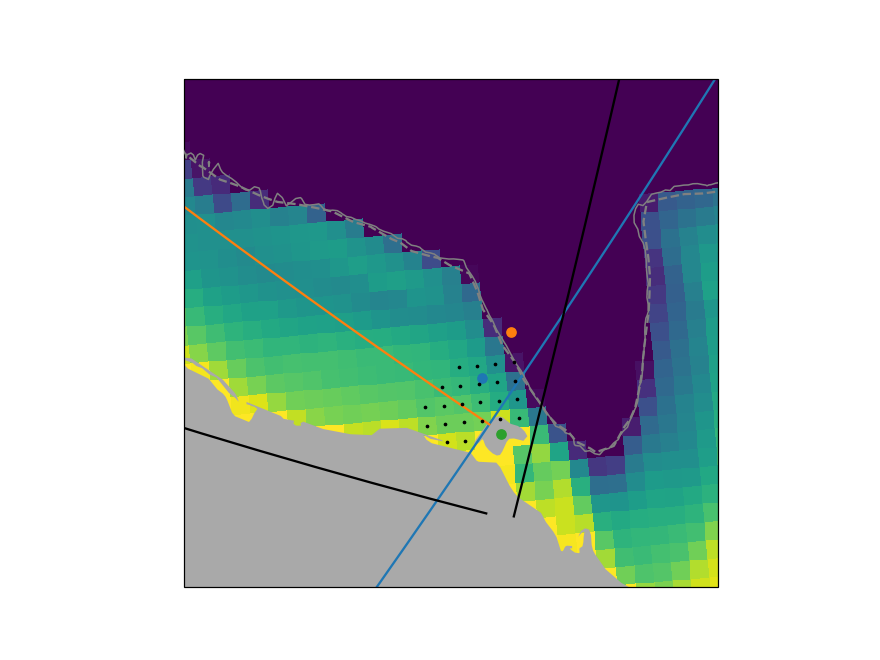

In [88]:
%matplotlib notebook
# initialize map
def wide_map(ax):
    ax.set_ylim(-2400000,-1900000)
    ax.set_xlim(-600000,450000)
    
def zoom_map(ax):
    ax.set_ylim(-2400000,-2000000)
    ax.set_xlim(-200000,200000)
    
map_proj = ccrs.NorthPolarStereo(central_longitude=-140)

fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,6))


wide_map(ax)
ax.set_facecolor('lightgray')
geomap.land(ax, scale = '10m', color='darkgray', alpha=1, fill_dateline_gap = False, zorder=2)
geomap.gebco_bathymetry(ax, file_path='/Volumes/Seagate_Jewell/KenzieStuff/GEBCO/GEBCO_2024/gebco_2024_n90.0_s55.0_w-180.0_e180.0.nc', 
                             crop_lat=(69, 73.5), crop_lon=(-170, -110), clat=5, clon=10, depth_shade=False, 
                             shade_zorder=0, depth_contours=True, contour_levels=[-100], 
                             contour_kwargs={'colors': 'gray', 'linewidths': 1, 'linestyles': 'solid', 'zorder': 100},
                             contour_labels=False, text_kwargs={'size': 10, 'color': 'gray', 'weight': 'normal', 'zorder': 100})


X = 'lon'
Y = 'lat'

plt.contour(sic[X], sic[Y], sic['sic'], levels=[thresh], colors=['r'], transform=ccrs.PlateCarree())
# plt.contour(sic[X], sic[Y], sic['sic'], levels=[60], colors=['r'], linewidths=[0.5],transform=ccrs.PlateCarree())
# plt.pcolormesh(sic[X], sic[Y], sic['sic'], vmin=thresh, vmax=100, transform=ccrs.PlateCarree())

plt.pcolormesh(sic[X], sic[Y], dsb.avg, vmin=-100, vmax=0, transform=ccrs.PlateCarree())
# plt.pcolormesh(sic[X], sic[Y], HI_dist, vmin=thresh, vmax=35, transform=ccrs.PlateCarree())
# plt.pcolormesh(sic[X], sic[Y], axis_dist, vmin=thresh, vmax=35, transform=ccrs.PlateCarree())

plt.plot(reg_lons2+360, reg_lats2, c='k', zorder=100, transform=ccrs.PlateCarree())
# plt.plot(reg_lons2+360, reg_lats2, c='gray', zorder=100, transform=ccrs.PlateCarree())

ax.scatter(-139.2582, 69.7718, transform=ccrs.PlateCarree())
ax.scatter(-138.9986, 69.9088, transform=ccrs.PlateCarree())

ax.scatter(-139.1, 69.6, zorder=1000, transform=ccrs.PlateCarree())

ax.plot(axisP['lon'], axisP['lat'], transform=ccrs.PlateCarree())
ax.plot(axis['lon'], axis['lat'], transform=ccrs.PlateCarree())


ax.scatter(sic['lon'][ni, nj], sic['lat'][ni, nj], s=2, c='k',transform=ccrs.PlateCarree(), zorder=100)
ax.contour(dsb.xx, dsb.yy, dsb.avg, levels=[-100], colors=['gray'], transform=sic['proj'])


In [43]:
def expand_along_edges(start_grid, reference_grid, checked_keys, footprint, keys, ii_size, jj_size):
    
    """ Search in reference_grid along edges of values in binary grid from start_grid, and add to start_grid
    start_grid: original grid of binary data to be expanding
    reference_grid: grid of binary data to reference when searching to expand start_grid
    checked_keys: list of keys already checked, to speed up by aoviding re-checking
    """
    
    # find edges of binary grid data
    grid_edge = find_boundaries(start_grid, mode='inner').astype(int)

    # iterate over edges and find new points to add
    ci, cj = np.where(grid_edge)
    
    for ii, jj in zip(ci, cj):
        
        
        check_key = keys[ii, jj]
        
        if check_key not in checked_keys:

            # find adjacent cells within radius of edge point
            footvals, footkeys = grab_footprint(footprint, reference_grid.astype(int), keys, ii, jj, ii_size, jj_size)

            # update binary grid
            for key in footkeys[footvals==1]:
                start_grid[np.where(keys == key)] = True
                
            checked_keys.append(check_key)
            
    return start_grid, checked_keys


def polynya_region_nanfrac(sic):

    # ensure that large data outage not occuring over polynya region
    polynya_lon = (sic['lon'] > 205) & (sic['lon'] < 225)
    polynya_lat = (sic['lat'] > 70) & (sic['lat'] < 73)
    polynya_region = polynya_lon & polynya_lat
    polynya_nan_frac = np.sum(np.isnan(sic['sic'][polynya_region])) / (sic['sic'][polynya_region].size)

    return polynya_nan_frac

def interatively_flood(io, jo, initial_grid, footprint, keys, ii_size, jj_size):
                        
    size = [0]
    counter = 0
    checked_keys = []

    initial = np.copy(initial_grid.astype(int))

    # find indices of polynya points intersecting initialization points
#                         polynya_keys = keys[ni,nj][polynyas[ni,nj]]
#                         i_pol, j_pol = np.where(keys == polynya_keys[0]) # grab first key and start from there

    # flood
    grid_flood = flood(initial, (io, jo), connectivity=2)
    size.append(np.sum(grid_flood)) # record current size

    # while polynya size keeps changing, iterate and add new adjacent points
    while size[-1] != size[-2]:

        counter+=1
        if counter > 100:
            break

        grid_flood, checked_keys = expand_along_edges(grid_flood, initial, 
                                                         checked_keys,
                                                         footprint, keys, ii_size, jj_size)
        size.append(np.sum(grid_flood)) # update size


    return grid_flood
                    
                    
def flood_ocean(sic, open_water, footprint, keys, ii_size, jj_size):
    
    # check polynya is not part of "open ocean"
    #----------------------------------------------------
    # define spatial region to check for "open ocean"
    ocean_lon = (sic['lon'] > 182) & (sic['lon'] < 187)
    ocean_lat = (sic['lat'] > 58) & (sic['lat'] < 60)
    ocean_region = ocean_lon & ocean_lat
    
    # find open water in ocean region
    open_water_region = ocean_region & open_water

    # find indices of polynya points intersecting initialization points
    oi, oj = np.where(open_water_region)

    ocean_size = [0]
    counter = 0
    checked_keys = []
    
    # flood from southwesternmost corner point
    ocean_flood = flood(open_water.astype(int), (oi[-1], oj[-1]), connectivity=2)
    ocean_size.append(np.sum(ocean_flood)) # record current size
    
    # while polynya size keeps changing, iterate and add new adjacent points
    while ocean_size[-1] != ocean_size[-2]:

        counter+=1
        if counter > 50:
            break

        # iterate through and find all ocean points
        ocean_flood, checked_keys = expand_along_edges(ocean_flood, open_water.astype(int), checked_keys,
                                         footprint, keys, ii_size, jj_size)
        ocean_size.append(np.sum(ocean_flood)) # update size
    
    return ocean_flood


def update_polynyas(sic, polynyas, open_water, footprint, keys, ii_size, jj_size):

    ocean_flood = flood_ocean(sic, open_water, footprint, keys, ii_size, jj_size)

    # update polynyas so any connected to open ocean are False
    #----------------------------------------------------
    polynyas[ocean_flood] = False


    return polynyas


def update_char(char, sic, polynya_flood, axis_dist, axisP_dist, HI_dist,  percentiles, dsb):
                            
    N = np.sum(polynya_flood)
    extent = np.sum(sic['area'][polynya_flood])

    char['N'] = np.append(char['N'], N)
    char['extent'] = np.append(char['extent'], extent)

    for d, group in zip(['l', 'w'], [axis_dist, axisP_dist]):

        dmin = np.min(group[polynya_flood])
        dmax = np.max(group[polynya_flood])
        dmean = np.mean(group[polynya_flood])

        char[f'{d}_min'] = np.append(char[f'{d}_min'], dmin)
        char[f'{d}_max'] = np.append(char[f'{d}_max'], dmax)
        char[f'{d}_mean'] = np.append(char[f'{d}_mean'], dmean)
        
        for per in percentiles:
            perc = np.percentile(group[polynya_flood], per)
            char[f'{d}_per{per}'] = np.append(char[f'{d}_per{per}'], perc)
            
    d = 'l'  
    for dirc in ['xx', 'yy']:
        char[f'{d}_max_{dirc}'] = np.append(char[f'{d}_max_{dirc}'], 
                                            sic[f'{dirc}'][polynya_flood][np.argmax(axis_dist[polynya_flood])])

    max_dist = np.max(HI_dist[polynya_flood])
    char['max_length'] = np.append(char['max_length'], max_dist)

    # find where maximum distance occurs
    final_x = sic['xx'][polynya_flood][np.argmax(HI_dist[polynya_flood])]
    final_y = sic['yy'][polynya_flood][np.argmax(HI_dist[polynya_flood])]
    final_lon, final_lat = ccrs.PlateCarree().transform_point(final_x, final_y, sic['proj'])
    char['max_length_lon'] = np.append(char['max_length_lon'], final_lon)
    char['max_length_lat'] = np.append(char['max_length_lat'], final_lat)

    # find bearing 
    HI_lon = -139.1
    HI_lat = 69.6
    az12,az21,dist = geod.inv(HI_lon,HI_lat,final_lon, final_lat)

    # direction toward max distance
    angle = 90 - az12
    char['max_length_direction'] = np.append(char['max_length_direction'], angle)
    
    
    # find where center of mass is located, and direction toward that
    final_x = np.nanmean(sic['xx'][polynya_flood])
    final_y = np.nanmean(sic['yy'][polynya_flood])
    final_lon, final_lat = ccrs.PlateCarree().transform_point(final_x, final_y, sic['proj'])
    char['com_lon'] = np.append(char['com_lon'], final_lon)
    char['com_lat'] = np.append(char['com_lat'], final_lat)
    
    # find bearing 
    HI_lon = -139.1
    HI_lat = 69.6
    az12,az21,dist = geod.inv(HI_lon,HI_lat,final_lon, final_lat)

    # direction toward max distance
    angle = 90 - az12
    char['com_direction'] = np.append(char['com_direction'], angle)
    char['com_length'] = np.append(char['com_length'], dist/1000)
    
    
    # find edges of binary grid data
    polynya_edge = find_boundaries(polynya_flood, mode='outer', connectivity=2).astype(int)

    border_xx = sic['xx'][polynya_edge==1]
    border_yy = sic['yy'][polynya_edge==1]
    interior_xx = sic['xx'][polynya_flood==1]
    interior_yy = sic['yy'][polynya_flood==1]

    
    for final_group, og_data in zip(['ice_edge_xx', 'ice_edge_yy', 
                                     'poly_interior_xx', 'poly_interior_yy'],
                                    [border_xx, border_yy, interior_xx, interior_yy]):
        
        # convert to long string and store
        all_str = ''
        for lon in og_data:
            all_str += f'_{lon}'

        char[final_group] = np.append(char[final_group], all_str)
        
        
    # save polynya depths
    poly_depths = dsb.avg.values[polynya_flood==1]
    all_str = ''
    for dd in poly_depths:
        all_str += f'_{np.round(dd, 2)}'
    char['depths'] = np.append(char['depths'], all_str)
    
    # save polynya depths
    poly_depths = dsb.avg.values[polynya_edge==1]
    all_str = ''
    for dd in poly_depths:
        all_str += f'_{np.round(dd, 2)}'
    char['border_depths'] = np.append(char['border_depths'], all_str)
    
    return char


<IPython.core.display.Javascript object>


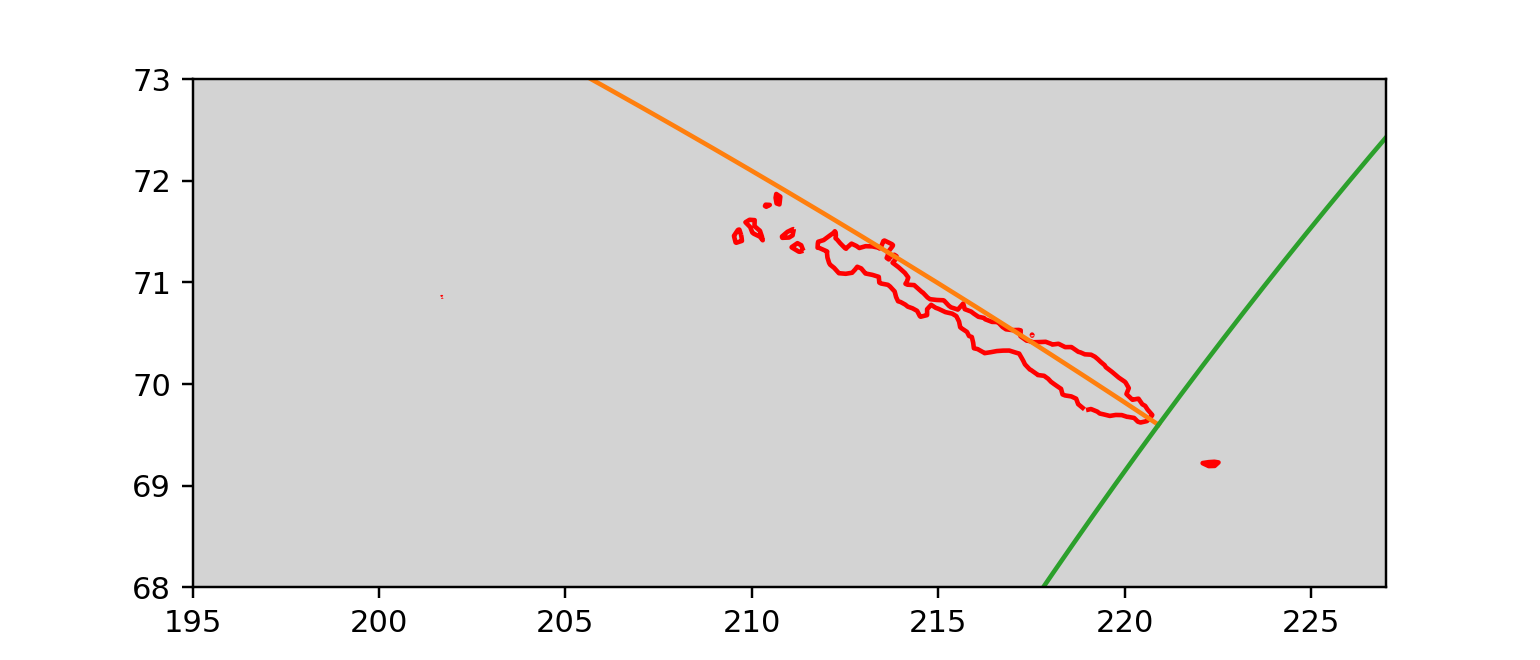

In [44]:
%matplotlib notebook

fig, ax= plt.subplots(figsize=(7,3))
ax.patch.set_facecolor('lightgray')
ax.set_ylim(68,73)
plt.xlim(195,227)

# fig, ax= plt.subplots()

X = 'lon'
Y = 'lat'

# plt.pcolormesh(sic[X], sic[Y], sic['sic'], vmin=thresh, vmax=100)

# plt.pcolormesh(sic[X], sic[Y], axisP_dist,cmap='RdBu_r', vmin=-100, vmax=100)
# plt.pcolormesh(sic[X], sic[Y], axis_dist,cmap='RdBu_r', vmin=-1000, vmax=1000)





plt.contour(sic[X], sic[Y], sic['sic'], levels=[thresh], colors=['r'])

plt.plot(reg_lons+360, reg_lats, c='k', zorder=100)


plt.plot(region_lons, region_lats)

plt.plot(axis['lon'], axis['lat'])
plt.plot(axisP['lon'], axisP['lat'])

## Run calculation!

In [94]:

# #============================================================
# # dates = pd.date_range(datetime(2018,11,1), datetime(2019,6,1))

# dates = pd.date_range(datetime(2019,11,5), datetime(2019,11,10))

# #============================================================


# ocean_flag = np.array([], dtype=bool)
# miss_flag = np.array([], dtype=bool)

# char = {}

# char['N'] = np.array([])
# char['extent'] = np.array([])

# orientations = ['l', 'w']
# percentiles = [5,25,50,75,95]


# for o in orientations:
#     char[f'{o}_min'] = np.array([])
#     char[f'{o}_max'] = np.array([])
#     char[f'{o}_mean'] = np.array([])
    
#     for per in percentiles:
#         char[f'{o}_per{per}'] = np.array([])


# years = [2019, 2020, 2021, 2022, 2023, 2024]
# years = np.arange(2003,2017)

# years = np.append(np.arange(2003,2012), np.arange(2013,2026))


# years = np.append(np.arange(2003,2012), np.arange(2013,2017))
# years = [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

# years = np.arange(2003,2026)

# years = [2017]


years = np.append(np.arange(2019,2026), np.arange(2003,2017))

# years = [2017,2018,2019,2020,2021,2022,2023,2024]




# years = [2023,2024,2025]

# years = np.append(np.arange(2023,2026), np.arange(2003,2020))

# years = [2003,2004]

# years = np.arange(2003,2021)

print(years)

# years = [2025]

%matplotlib inline

[2019 2020 2021 2022 2023 2024 2025 2003 2004 2005 2006 2007 2008 2009
 2010 2011 2012 2013 2014 2015 2016]


In [ ]:
starttime = datetime.now()

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

for year in years:
    
    #============================================================
    dates = pd.date_range(datetime(year-1,11,25), datetime(year,5,5))

#     dates = pd.date_range(datetime(year,4,5), datetime(year,4,25))

#     dates = [datetime(year,3,11)]
#     dates = [datetime(year-1,12,17), datetime(year-1,12,18)]

#     dates = pd.date_range(datetime(year,1,1), datetime(year,1,20))
    #============================================================

    # initialize dictionary
    #---------------------------------------------
    miss_flag = np.array([], dtype=bool)

    land_area = np.array([])
    ice_area = np.array([])
    ocean_area = np.array([])
    polynya_area = np.array([])
    spec_polynya_area = np.array([])
    

    char = {}

    char['N'] = np.array([])
    char['extent'] = np.array([])
    char['max_length'] = np.array([])
    char['max_length_direction'] = np.array([])
    
    char['com_length'] = np.array([])
    char['com_direction'] = np.array([])
    
    char['l_max_xx'] = np.array([])
    char['l_max_yy'] = np.array([])
    
    char['max_length_lon'] = np.array([])
    char['max_length_lat'] = np.array([])
    
    char['com_lon'] = np.array([])
    char['com_lat'] = np.array([])
    
    char['ice_edge_xx'] = np.array([])
    char['ice_edge_yy'] = np.array([])

    char['poly_interior_xx'] = np.array([])
    char['poly_interior_yy'] = np.array([])
    
    char['depths'] = np.array([])
    char['border_depths'] = np.array([])
    

    orientations = ['l', 'w']
    percentiles = [5,25,50,75,95]

    for o in orientations:
        char[f'{o}_min'] = np.array([])
        char[f'{o}_max'] = np.array([])
        char[f'{o}_mean'] = np.array([])

        for per in percentiles:
            char[f'{o}_per{per}'] = np.array([])


    # run calculations
    #---------------------------------------------
    for dd, date in enumerate(dates):

        if dd % 15 == 0:
            print(date)

        # try opening file:
        #---------------------
        try:
            sic = UNISIC.open_local_file(pd.to_datetime(date), res='6250', hem='n', 
                                         main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                                         crop=[850,1250,150,350], coordinates=True, area=True, 
                                         include_units=False,  quiet=True)    
        except:
            miss_flag = np.append(miss_flag, True)
            land_area = np.append(land_area, np.nan)
            ice_area = np.append(ice_area, np.nan)
            ocean_area = np.append(ocean_area, np.nan)
            polynya_area = np.append(polynya_area, np.nan)
            spec_polynya_area = np.append(spec_polynya_area, np.nan)

            for key in char.keys():
                char[key] = np.append(char[key], np.nan)

        # file is not missing:
        #---------------------
        else:
            
            # evaluate missing data fraction within poly region and whole area
            polynya_nan_frac = np.sum(np.isnan(sic['sic'][within_region]))/np.sum(within_region)
            total_nan_frac = np.sum(np.isnan(sic['sic']))/sic['sic'].size
            if (polynya_nan_frac > 0.3) or (total_nan_frac > 0.75):
                miss_flag = np.append(miss_flag, True)
                land_area = np.append(land_area, np.nan)
                ice_area = np.append(ice_area, np.nan)
                ocean_area = np.append(ocean_area, np.nan)
                polynya_area = np.append(polynya_area, np.nan)
                spec_polynya_area = np.append(spec_polynya_area, np.nan)
                for key in char.keys():
                    char[key] = np.append(char[key], np.nan)
                print(f'missing polynya region data on {date}: polynya_nan_frac = {polynya_nan_frac}')
            
            else:
                miss_flag = np.append(miss_flag, False)
                
                # binarize
                open_water = sic['sic'] <= thresh
                polynyas = np.copy((open_water) & (within_region == True))

                # if LOTS of open water (above 80% area which is ~ max ocean region)
                # reaches only 16% during huge Jan 16 2024 event
                # know that this is open ocean rather than polynya. Save time evaluating this:
                if np.sum(polynyas) / np.sum((within_region == True)) > 0.5:
                    ocean_flood = polynyas
                else:
                    # any "open ocean" within region
                    ocean_flood = flood_ocean(sic, open_water, footprint, keys, ii_size, jj_size)

                # mark any open ocean as not a polynya
                polynyas[ocean_flood] = False

                # find indices of polynya points intersecting initialization points
                polynya_keys = keys[ni,nj][polynyas[ni,nj]]

                if len(polynya_keys) > 0:
                    
#                     i_pol, j_pol = np.where(keys == polynya_keys[0]) # grab first key and start from there
#                     io, jo = i_pol[0], j_pol[0]
#                     polynya_flood = interatively_flood(io, jo, polynyas, footprint, keys, ii_size, jj_size)
#                     char = update_char(char, sic, polynya_flood, axis_dist, axisP_dist, HI_dist, percentiles)

                    # search through all keys (any open water w/in 50 km of polynya)
                    # will be part of polynya
                    polynya_flood = np.full(polynyas.shape, False)
                    included_keys = keys[polynya_flood]
                    for pp in polynya_keys:
                        
                        if pp not in included_keys: # if it's not already now included in the polynya, search around it
                            i_pol, j_pol = np.where(keys == pp) # grab key and start from there
                            io, jo = i_pol[0], j_pol[0]
                            polynya_initial = interatively_flood(io, jo, polynyas, footprint, keys, ii_size, jj_size)
                            polynya_flood+=polynya_initial
                            included_keys = keys[polynya_flood]
                        
                    char = update_char(char, sic, polynya_flood, axis_dist, axisP_dist, HI_dist, percentiles, dsb)

                else:
                    polynya_flood = np.full(polynyas.shape, False)
                    for key in char.keys():
                        char[key] = np.append(char[key], 0)


                all_cats = np.zeros(polynyas.shape)
                all_cats[open_water == False] = 1 # sea ice
                all_cats[ocean_flood == True] = 2 # "open ocean" water
                all_cats[(open_water == True) & (polynya_flood == False)] = 3 # "other" water not connected to polynya origin
                all_cats[polynya_flood == True] = 4 # "polynya" water
                all_cats[np.isnan(sic['sic'])] = 0 # land
                all_cats[within_region == False] = -1 # ignore outside region

                land_area = np.append(land_area, np.sum(sic['area'][all_cats == 0]))
                ice_area = np.append(ice_area, np.sum(sic['area'][all_cats == 1]))
                ocean_area = np.append(ocean_area, np.sum(sic['area'][all_cats == 2]))
                polynya_area = np.append(polynya_area, np.sum(sic['area'][all_cats == 3]))
                spec_polynya_area = np.append(spec_polynya_area, np.sum(sic['area'][all_cats == 4]))

                # plot data
                #----------
                fig, ax = plt.subplots(figsize=(5,2))
                ax.set_title(f'{date.strftime("%Y-%m-%d")} [sic <= {thresh}]')
                ax.set_xlim(202,225)
                ax.set_ylim(69,73)
                ax.patch.set_facecolor('lightgray')
                cat_norm = mpl.colors.BoundaryNorm(boundaries=[-1.5,-0.5,0.5,1.5,2.5,3.5,4.5], ncolors=6)
                cat_cmap = mpl.colors.ListedColormap(['None','gray', 'white','b', 'dodgerblue', 'magenta'])
#                 ax.pcolormesh(sic['lon'], sic['lat'], all_cats, cmap=cat_cmap, norm=cat_norm)
                ax.pcolormesh(sic['lon'], sic['lat'], sic['sic'], cmap=cmocean.cm.ice, vmin=0, vmax=100)
                ax.pcolormesh(sic['lon'], sic['lat'], all_cats == 2, cmap=mpl.colors.ListedColormap(['None','b']))
                ax.pcolormesh(sic['lon'], sic['lat'], all_cats == 3, cmap=mpl.colors.ListedColormap(['None','dodgerblue']))
                ax.pcolormesh(sic['lon'], sic['lat'], all_cats == 4, cmap=mpl.colors.ListedColormap(['None','magenta']))
        
                ax.plot(axis[X], axis[Y], lw=1,c='gray')
                ax.plot(axisP[X], axisP[Y], lw=1,c='gray')
                plt.plot(reg_lons2+360, reg_lats2, lw=1,c='k')
                
                ax.scatter(sic['lon'][ni, nj], sic['lat'][ni, nj], s=0.5,lw=0, c='gray', zorder=100)
                
#                 ax.contour(dsb.xx, dsb.yy, dsb.avg, levels=[-100], colors=['gray'], transform=sic['proj'])

                fig.savefig(f'/Users/mackenziejewell/Desktop/SBSpolynya-images/v7.6/img_{date.strftime("%Y-%m-%d")}_sic{thresh}.png', dpi=250, bbox_inches='tight')
                plt.clf()
                plt.close()


    # save to net cdf
    #----------------------------------------------

    data_vars = {}

    for key in list(char.keys()):

        # build long name
        if 'w' in key:
            dim = 'width'
        elif 'l' in key:
            dim = 'length'
        else:
            dim = 'total'

        if '_' in key:
            more = key.split('_')[1]
            if 'per' in more:
                more = f"{more.split('per')[1]}th percentile" 
        else:
            more = key

        long_name = f'{more} {dim}'

        # set units
        if key =='N':
            units="6.25 km cells"
        else:
            units = 'km'

        # construct data field
        data_vars[key] = (("time"), char[key], {'long_name': long_name, 'units': units})

    data_vars['land_extent'] = (("time"), land_area, {'long_name': 'land extent within region', 'units': 'km^2'})
    data_vars['ice_extent'] = (("time"), ice_area, {'long_name': 'ice extent within region', 'units': 'km^2'})
    data_vars['ocean_extent'] = (("time"), ocean_area, {'long_name': 'extent of water connected to Pacific Ocean water within region', 'units': 'km^2'})
    data_vars['other_polynya_extent'] = (("time"), polynya_area, {'long_name': 'extent of open water not connected to HI polynya or Pacific Ocean water within region', 'units': 'km^2'})
    data_vars['polynya_extent'] = (("time"), spec_polynya_area, {'long_name': 'extent of polynya forming near HI within region', 'units': 'km^2'})
    data_vars['miss_flag'] = (("time"), miss_flag, {'long_name': 'Flag for missing SIC data', 'units': 'None'})


    ds = xr.Dataset(data_vars, coords={"time": dates})   

    # save to file
    mainpath = '../data/polynya_size/'
    filename = f"daily_polynya_{dates[-1].year}_sic{thresh}_v7.6_radius{int(radius_in_km)}km.nc"
    ds.to_netcdf(mainpath+filename)

    
print(datetime.now()-starttime)

warnings.filterwarnings("default", category=UserWarning)

2018-11-25 00:00:00
2018-12-10 00:00:00
2018-12-25 00:00:00
2019-01-09 00:00:00
2019-01-24 00:00:00
2019-02-08 00:00:00
2019-02-23 00:00:00
2019-03-10 00:00:00
missing polynya region data on 2019-03-18 00:00:00: polynya_nan_frac = 1.0
2019-03-25 00:00:00
2019-04-09 00:00:00
2019-04-24 00:00:00
2019-11-25 00:00:00
2019-12-10 00:00:00
2019-12-25 00:00:00
2020-01-09 00:00:00
2020-01-24 00:00:00
2020-02-08 00:00:00
2020-02-23 00:00:00
2020-03-09 00:00:00
2020-03-24 00:00:00
2020-04-08 00:00:00
2020-04-23 00:00:00
2020-11-25 00:00:00
2020-12-10 00:00:00
2020-12-25 00:00:00
2021-01-09 00:00:00
2021-01-24 00:00:00
2021-02-08 00:00:00
2021-02-23 00:00:00
2021-03-10 00:00:00
2021-03-25 00:00:00
2021-04-09 00:00:00
2021-04-24 00:00:00
2021-11-25 00:00:00
2021-12-10 00:00:00
2021-12-25 00:00:00
2022-01-09 00:00:00
2022-01-24 00:00:00
2022-02-08 00:00:00
2022-02-23 00:00:00
missing polynya region data on 2022-03-02 00:00:00: polynya_nan_frac = 1.0
2022-03-10 00:00:00


In [ ]:
# # plt.pcolormesh(sic['lon'], sic['lat'], polynya_flood, zorder=-1)
# # plt.pcolormesh(sic['lon'], sic['lat'], polynya_edge, )

# plt.scatter(border_lon, border_lat, c='r', zorder=0, s=1)
# plt.scatter(interior_lon, interior_lat, c='b', zorder=0, s=1)

# plt.xlim(210,225)
# plt.ylim(67,73)

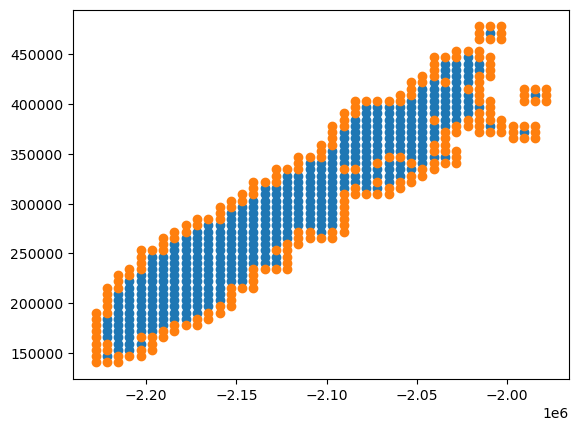

In [182]:
fig, ax = plt.subplots()

t = 1

all_xx = ds.poly_interior_xx.sel(time=ds.time[t]).values.item()
all_yy = ds.poly_interior_yy.sel(time=ds.time[t]).values.item()
plt.scatter(np.array(all_xx.split('_')[1:]).astype(float),
            np.array(all_yy.split('_')[1:]).astype(float))

all_xx = ds.ice_edge_xx.sel(time=ds.time[t]).values.item()
all_yy = ds.ice_edge_yy.sel(time=ds.time[t]).values.item()
plt.scatter(np.array(all_xx.split('_')[1:]).astype(float),
            np.array(all_yy.split('_')[1:]).astype(float))

<IPython.core.display.Javascript object>


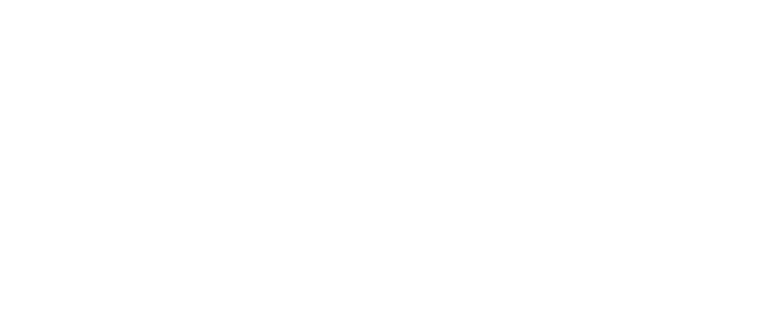

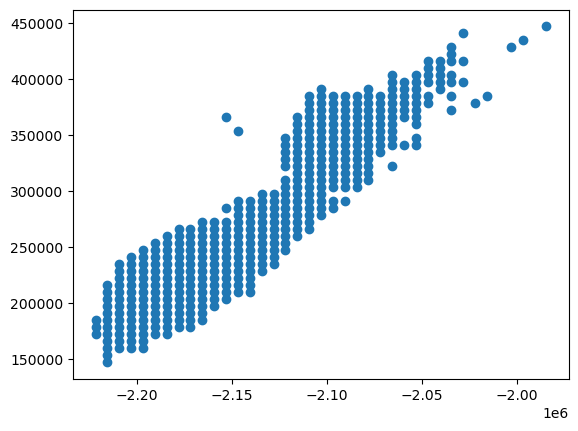

In [178]:
fig, ax = plt.subplots()
plt.scatter(np.array(all_xx.split('_')[1:]).astype(float),
            np.array(all_yy.split('_')[1:]).astype(float))

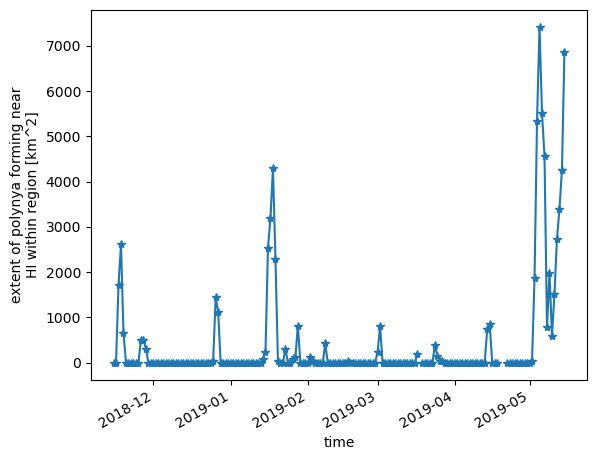

In [220]:

# ds.other_polynya_extent.plot(marker='*')
# ds.land_extent.plot(marker='*')
ds.polynya_extent.plot(marker='*')



In [200]:
ds.miss_flag

<xarray.DataArray 'miss_flag' (time: 14)>
array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])
Coordinates:
  * time     (time) datetime64[ns] 2023-12-25 2023-12-26 ... 2024-01-07
Attributes:
    long_name:  Flag for missing SIC data
    units:      None

In [140]:
polynya_keys

array([], dtype=int64)

In [ ]:
# v1 --> v2: cut off portions of polynyas behind HI (Cape Bathurst flaw lead)

In [ ]:
# missing polynya region data on 2017-11-25 00:00:00
# missing polynya region data on 2019-03-18 00:00:00
# missing polynya region data on 2022-03-02 00:00:00
# missing polynya region data on 2024-04-17 00:00:00